# Lale's AutoPipeline Operator

The `lale.lib.lale.AutoPipeline` operator automatically creates a pipeline for a dataset.
It is designed for simplicity, requiring minimum configuration to get started.
You can use it for an initial experiment with new data. See also the
[API documentation](https://lale.readthedocs.io/en/latest/modules/lale.lib.lale.auto_pipeline.html).

## Dataset

This demonstration uses the [credit-g](https://www.openml.org/d/31) dataset from OpenML.
The dataset has both categorical features, represented as strings, and
numeric features. For illustration purposes, we also add some missing values,
represented as `NaN`. Printing the last few samples of the training data reveals
`credit_amount=NaN` for sample number 763.

In [1]:
import lale.datasets.openml
import lale.helpers
(orig_train_X, train_y), (test_X, test_y) = \
    lale.datasets.openml.fetch('credit-g', 'classification', preprocess=False)
train_X = lale.helpers.add_missing_values(orig_train_X, seed=42)
train_X.tail(6)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
763,no checking,21.0,critical/other existing credit,new car,NaN,no known savings,>=7,4.0,male single,none,4.0,no known property,30.0,none,for free,1.0,high qualif/self emp/mgmt,1.0,yes,yes
835,<0,12.0,no credits/all paid,new car,1082.0,<100,1<=X<4,4.0,male single,none,4.0,car,48.0,bank,own,2.0,skilled,1.0,none,yes
192,0<=X<200,27.0,existing paid,business,3915.0,<100,1<=X<4,4.0,male single,none,2.0,car,36.0,none,own,1.0,skilled,2.0,yes,yes
629,no checking,9.0,existing paid,education,3832.0,no known savings,>=7,1.0,male single,none,4.0,real estate,64.0,none,own,1.0,unskilled resident,1.0,none,yes
559,0<=X<200,18.0,critical/other existing credit,furniture/equipment,1928.0,<100,<1,2.0,male single,none,2.0,real estate,31.0,none,own,2.0,unskilled resident,1.0,none,yes
684,0<=X<200,36.0,delayed previously,business,9857.0,100<=X<500,4<=X<7,1.0,male single,none,3.0,life insurance,31.0,none,own,2.0,unskilled resident,2.0,yes,yes


## Sklearn Interface

We designed the AutoPipeline operator to follow sklearn's init-fit-predict
conventions to make it easy to use for anyone familiar with sklearn.

- During initialization, you can configure the behavior of the operator.
  Here, we set `prediction_type='classification'`; AutoPipeline also supports
  `'regression'`. The `max_opt_time` is the timeout in seconds for finding a
  pipeline for the dataset.
- The call to `fit` initiates training, which tries out various pipelines
  on the dataset.
- Finally, after training, `predict` makes predictions using the best found
  pipeline.

In [2]:
from lale.lib.lale import AutoPipeline
trainable = AutoPipeline(prediction_type='classification', max_opt_time=90)

In [3]:
%%time
trained = trainable.fit(train_X, train_y)

CPU times: user 29.2 s, sys: 2.53 s, total: 31.7 s
Wall time: 2min 8s


In [4]:
predicted = trained.predict(test_X)

The result of `predict` can then be either used directly (e.g., printed),
or passed to other sklearn functions (e.g., for scoring).

In [5]:
from sklearn.metrics import accuracy_score
print(f'first 15 predictions: {predicted[:15]}')
print(f'accuracy {accuracy_score(predicted, test_y):.1%}')

first 15 predictions: [1 1 1 1 1 1 1 1 1 0 0 1 1 1 1]
accuracy 76.1%


## Inspecting Results

After training, you can look at a leaderboard of all the pipelines tried
during the search by calling the `summary` method.

In [6]:
trained.summary()

,log_loss,loss,status,tid,time
name,,,,,
forest_all,0.537487,-0.735821,ok,NaN,2.879790
p2,0.558104,-0.710448,ok,2.0,2.915199
baseline,NaN,-0.695522,ok,NaN,0.157689
p3,0.619019,-0.695522,ok,3.0,6.633928
p0,0.594323,-0.689552,ok,0.0,2.956170
p1,0.611665,-0.689552,ok,1.0,3.010883
forest_num,0.609914,-0.680597,ok,NaN,1.364204
p4,NaN,NaN,new,4.0,NaN


The `get_pipeline` method lets you retrieve any pipeline by name.
By default, when no name is specified, it returns the best pipeline
found, in other words, the pipeline with the lowest loss in the
leaderboard.
You can call `predict` on that pipeline in typical sklearn fashion.
Furthermore, you can inspect that pipeline by calling `visualize`.

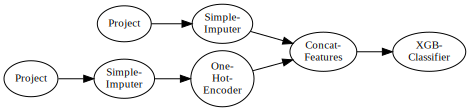

In [7]:
best_found = trained.get_pipeline()
best_found.visualize()

The visualization reveals the operators from which the pipeline is
composed. Since our example dataset contains both numeric features and
categorical features, the pipeline contains two preprocessing paths,
using `Project` to keep only the relevant columns.
When you hover the mouse pointer over an operator in the visualization,
a tooltip shows how it is configured. Furthermore, if you click on an
operator in the visualization, you get to a documentation page
for that operator.
You can also pretty-print any pipeline found during the search back as
Python code to better understand how its operators were configured.

In [8]:
best_found.pretty_print(ipython_display=True)

```python
from lale.lib.lale import Project
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from lale.lib.lale import ConcatFeatures
from xgboost import XGBClassifier
import lale

lale.wrap_imported_operators()
project_0 = Project(
    columns={"type": "number"},
    drop_columns=lale.lib.lale.categorical(max_values=5),
)
project_1 = Project(columns=lale.lib.lale.categorical(max_values=5))
simple_imputer_1 = SimpleImputer(strategy="most_frequent")
one_hot_encoder = OneHotEncoder(handle_unknown="ignore")
pipeline = (
    (
        (project_0 >> SimpleImputer())
        & (project_1 >> simple_imputer_1 >> one_hot_encoder)
    )
    >> ConcatFeatures
    >> XGBClassifier()
)
```

## Next Steps

You can try out the AutoPipeline operator on your own data.
Alternatively, if you want more control, you also plan your own pipelines,
then use Lale to do automated algorithm selection and hyperparameter tuning
on them. Check out the other [example
notebooks](https://github.com/IBM/lale/tree/master/examples) for Lale,
and in particular, the [introductory
guide](https://nbviewer.jupyter.org/github/IBM/lale/blob/master/examples/docs_guide_for_sklearn_users.ipynb).